In [42]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import feedexp3

def evaluate_parallel(nbCores, n_folds, horizon, alg, game):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, outcome_distribution)
    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''
  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class Evaluation:

    def __init__(self, horizon, outcome_distribution ):

        self.horizon = horizon
        self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        np.random.seed(job_id)
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p=self.outcome_distribution, size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, jobid):

        cumRegret = np.zeros( self.horizon )
        cumSufferedLoss = 0
        cumAllLosses = np.zeros( game.n_actions )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]
            feedback =  self.get_feedback(game, action, outcome )

            alg.update(game,  action, feedback)
            # print('outcome', outcome, 'action',action, 'eta', alg.eta, 'gamma', alg.gamma, 'pbt',alg.pbt, 'pbt_hat', alg.pbt_hat)

            # policy suffers loss and regret
            cumAllLosses += game.LossMatrix[...,outcome]
            cumSufferedLoss += game.LossMatrix[action,outcome]
            cumRegret[t] = cumSufferedLoss - min(cumAllLosses)

        return cumRegret


def W(self, mathcal_N, N_bar, observer_vector ):
    W = np.zeros( len(N_bar) )
    for pair in mathcal_N:
        for k in N_bar:
            value = np.fabs( observer_vector[ pair[0] ][ pair[1] ][k] ).max()
            W[k] = max( W[k], value  )
    return W


def eval_cpbvanilla_parallel(task, nbCores, n_folds, horizon, alpha):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.cpb_vanilla_v2 ,alpha ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''

  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class SyntheticCase:

    def __init__(self, LossMatrix, FeedbackMatrix, horizon ):
 
        self.LossMatrix = LossMatrix 
        self.FeedbackMatrix = FeedbackMatrix 
        

        self.horizon = horizon
        self.n_actions = len(self.LossMatrix)
        self.n_outcomes = len(self.LossMatrix[0])

    def set_outcomes(self, job_id):
        np.random.seed(job_id)
        #self.means = runif_in_simplex( len( LossMatrix[0] ) )
        self.outcomes = np.random.choice( self.n_outcomes , p= [0.05, 0.95], size= self.horizon) # [0.05, 0.95]

    def get_feedback(self, FeedbackMatrix, action, outcome):
        return FeedbackMatrix[ action ][ outcome ] 

    def W(self, mathcal_N, N_bar, observer_vector ):
        N = len(N_bar)
        W = np.zeros( N )
        for pair in mathcal_N:
            for k in range(N):
                value = np.fabs( observer_vector[ pair[0] ][ pair[1] ][k] ).max()
                print(value)
                W[k] = max( W[k], value  )
        return W

    def cpb_vanilla_v2(self, alpha, job_id):

        cumRegret = np.zeros( self.horizon )
        cumSufferedLoss = 0
        cumAllLosses = np.zeros( self.n_actions )

        self.set_outcomes(job_id)

        N_bar = set(range(self.n_actions))
        M_bar = set(range(self.n_outcomes))
        e = np.eye(self.n_outcomes)
        A = geometry.get_alphabet_size(self.FeedbackMatrix)
        n = np.zeros(self.n_actions)
        nu = [  np.zeros( A ) for i in self.FeedbackMatrix ] 
        
        mathcal_P = [ a for a in N_bar if geometry.isParetoOptimal(a, self.LossMatrix )] # set of pareto optimal actions
        mathcal_N = [ pair for pair in list( itertools.combinations(N_bar, 2) ) if geometry.areNeighbours(pair[0], pair[1], self.LossMatrix ) ] #set of unordered neighboring actions

        S_vectors = geometry.get_signal_matrices(self.FeedbackMatrix)

        # observer_set = collections.defaultdict(dict)
        # for pair in mathcal_N : 
        #     if geometry.ObservablePair(pair[0], pair[1], self.LossMatrix, [geometry.signal_vecs(i, self.FeedbackMatrix) for i in geometry.Neighbourhood(pair[0], pair[1], self.LossMatrix )]):
        #         observer_set [ pair[0] ][ pair[1] ] =   mathcal_N_plus[ pair[0] ][ pair[1] ] 
        #     else:
        #         observer_set [ pair[0] ][ pair[1] ] = None
        #         print('Observer set -- not implemented')

        observer_vector = collections.defaultdict(dict)
        for pair in mathcal_N :
            observer_vector[ pair[0] ][ pair[1] ] = geometry.get_observer_vector(pair ,self.LossMatrix ,self.FeedbackMatrix, S_vectors ) # np.array(  [ [0, 0.33],[-0.33,0.66] ] ) 
        print( observer_vector )


        W = self.W( mathcal_N, N_bar, observer_vector )
        print('W', W)

        # print('mathcal P', mathcal_P)
        # print('mathcal N', mathcal_N)

        for t in range(self.n_actions):

            action  = t
            outcome = self.outcomes[t]
            # Y = geometry.signal_vecs(action, self.FeedbackMatrix) @ e[outcome]
            n[action] += 1
            # nu[action] += Y
            nu[action][outcome] += 1

            # policy suffers loss and regret
            cumAllLosses += self.LossMatrix[...,outcome]
            cumSufferedLoss += self.LossMatrix[action,outcome]
            cumRegret[t] = cumSufferedLoss - min(cumAllLosses)

                    
        for t in range(self.n_actions, self.horizon):

            mathcal_P_t = mathcal_P
            mathcal_N_t = mathcal_N

            outcome = self.outcomes[t]
            half_space = []

            for pair in mathcal_N:
                # print( 'inside', [  observer_vector[ pair[0] ][ pair[1] ][k].T * v[k]/n[k]   for k in mathcal_N_plus ] )
                d_ij, c = 0, 0 
                for k in range(len(N_bar)):
                    d_ij +=   observer_vector[ pair[0] ][ pair[1] ][k].T.dot(nu[k])/n[k] 
                    c += np.fabs(  observer_vector[ pair[0] ][ pair[1] ][k] ).max()  * np.sqrt(alpha * np.log(t) / n[k] )  
                print('d_ij',d_ij, 'c', c)
                        
                if abs( d_ij ) >= c:
                    half_space.append(  ( pair, np.sign(d_ij) ) )
                else:
                    half_space.append(  ( pair, 0 ) )

            # print('halfspace', half_space)

            #print('P before:',mathcal_P)
            #mathcal_P_t = geometry.getParetoOptimalActions(LossMatrix, half_space) #get_P_t(half_space, self.LossMatrix, mathcal_P, mathcal_N)
            #print('P after:',mathcal_P)

            # print('N before:',mathcal_N)
            mathcal_N_t = geometry.getNeighbors(LossMatrix, mathcal_N, half_space) #get_N_t(half_space, self.LossMatrix, mathcal_P, mathcal_N)
            # print('N after:',mathcal_N)

            mathcal_N_plus = collections.defaultdict(dict)
            for pair in mathcal_N_t:
                mathcal_N_plus[ pair[0] ][ pair[1] ] = geometry.get_neighborhood_action_set(pair, N_bar, self.LossMatrix )
            # print('mathcal_N_plus', mathcal_N_plus)
            
            #print('mathcal_n_plus', mathcal_N_plus)
            Q = reduce( np.union1d, [ mathcal_N_plus[ pair[0] ][ pair[1] ]  for pair in mathcal_N_t ]  )
            # print('Q', Q)
            values = [ W[k]**2/n[k] for k in Q ]

            action = np.argmax(values)
            Y = S_vectors[action] @ e[outcome]
            n[action] += 1
            nu[action][outcome] += 1

            # print('values', values, 'action', action, 'n', n, 'nu', nu)

            # policy suffers loss and regret
            cumAllLosses += self.LossMatrix[...,outcome]
            cumSufferedLoss += self.LossMatrix[action,outcome]
            cumRegret[t] = cumSufferedLoss - min(cumAllLosses)

        return np.array(cumRegret)

In [25]:

def get_observer_vector(pair, L,H, observer_set):
    
    Lij = L[pair[0],...] - L[pair[1],...]
    S_vectors = [ geometry.signal_vecs(k, H) for k in observer_set ]
    # print(S_vectors)
    stacked_S =  np.linalg.pinv(  np.vstack( S_vectors ).T )

    resultat = stacked_S * Lij 
    v_ij = resultat.T[0]
    length = [ len(k)  for k in S_vectors]
    v_ij = iter( v_ij )
    return [ np.array( list( islice( v_ij, i)) ) for i in length] 

L = np.array( [ [1, 0], [0, 1] ] )
H =  np.array([ [1, 1],[1, 0] ])

get_observer_vector( [0,1], L, H, [0,1] )

[array([0.33333333]), array([-0.33333333,  0.66666667])]

defaultdict(<class 'dict'>, {0: {1: array([[ 0.00000000e+00, -2.22044605e-16],
       [-1.00000000e+00,  1.00000000e+00]])}})
2.220446049250313e-16
1.0000000000000002
W [2.22044605e-16 1.00000000e+00]
d_ij 1.0 c 1.1774100225154758
d_ij 1.0 c 1.048147073968206
d_ij 1.0000000000000002 c 0.9613512577339228
d_ij 1.0 c 0.8970612889970515
d_ij 1.0000000000000002 c 0.8465835975798394
d_ij 1.0000000000000002 c 0.8053798584219576
d_ij 1.0000000000000002 c 0.7707957931681184
d_ij 1.0 c 0.7411519036837564
d_ij 1.0000000000000002 c 0.7153220087631167
d_ij 1.0000000000000002 c 0.6925164651903053
d_ij 1.0000000000000002 c 0.6721615944491063
d_ij 1.0000000000000002 c 0.6538283869463943
d_ij 1.0000000000000002 c 0.6371882139060719
d_ij 1.0000000000000002 c 0.6219841753961061
d_ij 1.0000000000000002 c 0.6080119211813519
d_ij 1.0 c 0.5951064341838592
d_ij 1.0000000000000002 c 0.5831326917804208
d_ij 1.0000000000000002 c 0.5719789214420842
d_ij 1.0000000000000002 c 0.5615516354899821
d_ij 1.0000000000000

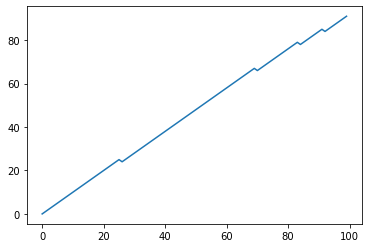

In [43]:
n_cores = 16
horizon = 100
n_folds = 25

LossMatrix = np.array( [ [1, 0], [0, 1] ] )
FeedbackMatrix =  np.array([ [1, 1],[1, 0] ])

task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 
result = task.cpb_vanilla_v2( 2, 25)  
plt.plot(result)

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

# plt.legend()

In [40]:
n_cores = 16
n_folds = 25
horizon = 100

outcome_distribution = [0.05, 0.95] 

nbCores: 16 nbFolds: 25 Horizon: 100
nbCores: 16 nbFolds: 25 Horizon: 100


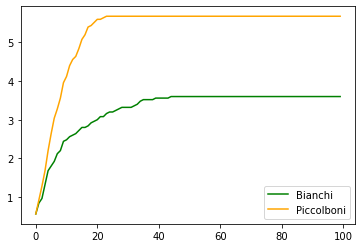

In [41]:
game = games.apple_tasting(False)

alg = feedexp3.FeedExp3(  game, horizon, 'Bianchi',)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
plt.plot(  np.mean( result1 , 0 ) , label = 'Bianchi', color = 'green' )

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
plt.plot(  np.mean( result2 , 0 ) , label = 'Piccolboni', color = 'orange' )

plt.legend()

# result = evaluate_parallel(n_cores, n_folds, horizon, feedexp3, game)

# task = Evaluation(horizon, outcome_distribution)
# result = task.eval_policy_once(feedexp3, game, 30)
# plt.plot(result)

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

# plt.legend()

In [ ]:


game = games.bandit(False)

alg = feedexp3.FeedExp3(  game, horizon, 'Bianchi',)
result = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'green' )

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'orange' )

plt.legend()
# task = Evaluation(horizon, outcome_distribution)
# result = task.eval_policy_once(feedexp3, game, 30)
# plt.plot(result)

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 


# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

# plt.legend()

In [ ]:


game = games.label_efficient()

alg = feedexp3.FeedExp3(  game, horizon, 'Bianchi',)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
plt.plot(  np.mean( result1 , 0 ) , label = 'Bianchi', color = 'green' )

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
plt.plot(  np.mean( result2 , 0 ) , label = 'Piccolboni', color = 'orange' )

plt.legend()

# task = Evaluation(horizon, outcome_distribution)
# result = task.eval_policy_once(feedexp3, game, 30)
# plt.plot(result)

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

# plt.legend()

In [ ]:
import ppl
M = 2
p = [ppl.Variable(j) for j in range(M)]
    
# declare polytope constraints
cs = ppl.Constraint_System()
    
# probabilies constraints on p
cs.insert( sum( p[j] for j in range(M)) == 1 )
for j in range(M):
    cs.insert(p[j] >= 0)

cs.insert(p[0] - p[1] <= 0)   
cs.insert(p[1] - p[0] <= 0)   

poly = ppl.C_Polyhedron(cs)

poly.minimized_generators()